In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from script.plotDisplay import plotDisplay

In [2]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


# First test case

In [3]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
callback_interval = 100
tensorboard_dir = "./log/"
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [1.0],
    [-1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.9723070278819597, -0.0830382487864254]], bias: [0.0], input_size: 2, output_size: 1 }]
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)


In [4]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    1,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [0.9999653]
Sample [0. 1.] , predictions = [-0.99997623]
Sample [1. 0.] , predictions = [0.99999905]
ndim = 1


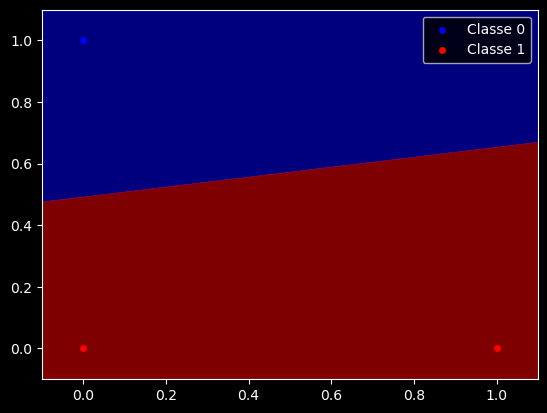

In [5]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


plotDisplay(X_train, y_train, nn, mlp_model)


mlp_model.mlpFree(nn)

# Xor test case

In [19]:
neurons_size = np.array([2, 2, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.0790283268623031, -0.7027205397114735], [-0.27130039286720153, 0.2758736932222132]], bias: [0.0, 0.0], input_size: 2, output_size: 2 }, NeuralMatrix { matrix: [[0.2374904385784382, 0.037346417014829214]], bias: [0.0], input_size: 2, output_size: 1 }]


In [20]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    1,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [-0.99547204]
Sample [0. 1.] , predictions = [0.96787614]
Sample [1. 0.] , predictions = [0.96779493]
Sample [1. 1.] , predictions = [-0.94025547]
ndim = 1


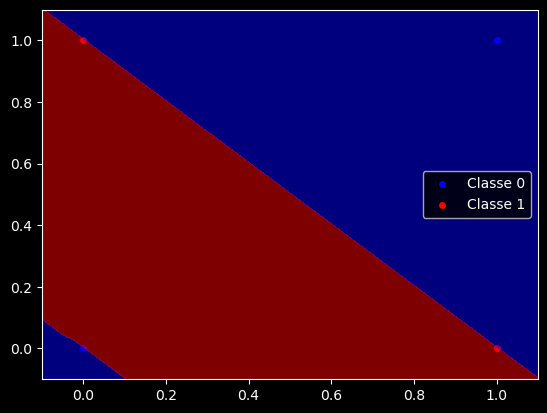

In [21]:
predictions = []
for k in range(len(X_train)):
    prediction = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions.append(prediction.tolist())
    print("Sample", X_train[k], ", predictions =", prediction)


plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class test

In [9]:
neurons_size = np.array([2, 3], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [0, 3.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)


layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.1751588922830818, -0.6248367562635639], [-0.16365388929877778, -0.2620676576782488], [0.5745212460039815, -0.9256286047027058]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [10]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    3,
    epochs,
    16,
    True,  
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [1. 1.] , predictions = [9.98742799e-01 8.19074036e-04 4.38127076e-04]
Sample [5. 5.] , predictions = [2.09561982e-04 9.99790412e-01 2.62699763e-08]
Sample [0. 3.] , predictions = [1.98975075e-04 4.48041445e-05 9.99756221e-01]
ndim = multi


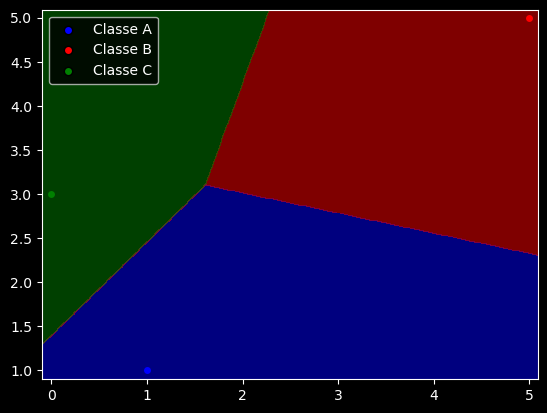

In [11]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Simple linear test

In [12]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [-3.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.5113148212785465]], bias: [0.0], input_size: 1, output_size: 1 }]


In [13]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [-3.]
Sample [7.] , predictions = [2.]


# Linear test

In [15]:
neurons_size = np.array([1, 10, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.05553881012462769], [-0.7725635780835414], [-0.9894484727610342], [-0.6680902444995063], [-0.7333564640535788], [-0.22724338373643693], [-0.5288578621663831], [-0.10007982467212662], [-0.9156768795755061], [0.29791340287707024]], bias: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], input_size: 1, output_size: 10 }, NeuralMatrix { matrix: [[0.7463161297022949, -0.534216501158713, 0.054500041710731306, -0.7213799259143201, 0.8954856554434909, 0.02418102995157323, -0.41693574656649535, 0.889387996000953, 0.49308741535588085, 0.025166873756005348]], bias: [0.0], input_size: 10, output_size: 1 }]


In [16]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [1.62661562]
Sample [7.] , predictions = [1.62661562]
Sample [9.] , predictions = [1.62661562]


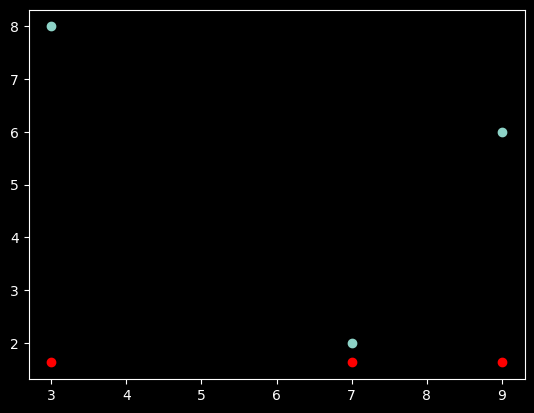

In [18]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()